In [75]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import PowerNorm
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np

## Load the spatial data

In [63]:
# Path to GeoJSON file
archivo_geojson = "divisions-administratives-v2r1-municipis-1000000-20240705.json"


# Load
map_data = gpd.read_file(archivo_geojson)

# Stablish 'geometry' column with the spatial information
map_data = map_data.set_geometry("geometry")

map_data.head(n=2)

,CODIMUNI,NOMMUNI,CAPMUNI,AREAM5000,CODICOMAR,NOMCOMAR,CAPCOMAR,CODIVEGUE,NOMVEGUE,CAPVEGUE,CODIPROV,NOMPROV,CAPPROV,geometry
0,080018,Abrera,Abrera,19.9781,11,Baix Llobregat,Sant Feliu de Llobregat,01,Barcelona,Barcelona,08,Barcelona,Barcelona,"MULTIPOLYGON (((1.92486 41.53663, 1.92197 41.5..."
1,080023,Aguilar de Segarra,Aguilar de Segarra,43.2198,07,Bages,Manresa,07,Catalunya Central,*,08,Barcelona,Barcelona,"MULTIPOLYGON (((1.61829 41.76885, 1.61278 41.7..."


In [64]:
population_data= pd.read_csv("census_migrants2021_utf8.csv", encoding="utf-8")
population_data.head(n=2)

,Categoria,(1) Población,Población extranjera. Total,Población extranjera. % vert.,Población extranjera. % sobre (1)
0,Barcelona,1636732,348302,27.85,21.28
1,"Hospitalet de Llobregat, l'",264657,58685,4.69,22.17


## Associate municipalities with codes

In [65]:
# Function to associates municipalities with their codes using the municipality_code.txt file
def cargar_asociacion(filepath):
    """
    Carga la asociación código-municipio desde un archivo .txt y la devuelve como un diccionario.
    """
    asociacion = {}
    with open(filepath, "r") as file:
        for line in file:
            codigo, municipality = line.strip().split(":")
            asociacion[municipality] = codigo
    return asociacion

# Load the codes
codigo_municipio_dict = cargar_asociacion("municipality_code.txt")

# Función para obtener el código de un municipio
def obtain_code(municipality):
    """
    Devuelve el código correspondiente al municipio proporcionado.
    Si el municipio no existe en la asociación, devuelve None.
    """
    return codigo_municipio_dict.get(municipality, None)

# Crear una nueva columna "Codigo" en population_data
population_data['Codigo'] = population_data['Categoria'].apply(obtain_code)

# Reorganizar las columnas para que "Codigo" sea la primera
population_data = population_data[['Codigo'] + [col for col in population_data.columns if col != 'Codigo']]

population_data.head(n=2)

,Codigo,Categoria,(1) Población,Población extranjera. Total,Población extranjera. % vert.,Población extranjera. % sobre (1)
0,08019,Barcelona,1636732,348302,27.85,21.28
1,08101,"Hospitalet de Llobregat, l'",264657,58685,4.69,22.17


In [66]:
# Truncar la columna CODIMUNI en map_data a 5 dígitos
map_data['Truncated_CODIMUNI'] = map_data['CODIMUNI'].astype(str).str[:5]

# Realizar el merge utilizando el código de 5 dígitos
merged_data = map_data.merge(
    population_data,
    left_on='Truncated_CODIMUNI',    # Columna truncada de map_data             
    right_on='Codigo',               # Columna de population_data
    how='left'                      # Merge solo con coincidencias
)

# Eliminar la columna auxiliar 'Truncated_CODIMUNI' si no es necesaria
merged_data.drop(columns=['Truncated_CODIMUNI'], inplace=True)

merged_data.head(n=2)

,CODIMUNI,NOMMUNI,CAPMUNI,AREAM5000,CODICOMAR,NOMCOMAR,CAPCOMAR,CODIVEGUE,NOMVEGUE,CAPVEGUE,CODIPROV,NOMPROV,CAPPROV,geometry,Codigo,Categoria,(1) Población,Población extranjera. Total,Población extranjera. % vert.,Población extranjera. % sobre (1)
0,080018,Abrera,Abrera,19.9781,11,Baix Llobregat,Sant Feliu de Llobregat,01,Barcelona,Barcelona,08,Barcelona,Barcelona,"MULTIPOLYGON (((1.92486 41.53663, 1.92197 41.5...",08001,Abrera,12620.0,842.0,0.07,6.67
1,080023,Aguilar de Segarra,Aguilar de Segarra,43.2198,07,Bages,Manresa,07,Catalunya Central,*,08,Barcelona,Barcelona,"MULTIPOLYGON (((1.61829 41.76885, 1.61278 41.7...",08002,Aguilar de Segarra,286.0,6.0,<0.01,2.10


## Merge faith data (with years)

In [67]:
# Cargar el archivo CSV
centres_data = pd.read_csv("ReligionCentres_CAT.csv")

# Inicializar el dataframe vacío para los resultados
centres_faith = pd.DataFrame()

# Definir las categorías de religiones principales
categories = {
    "Catholic": "Església catòlica",
    "Evangelical": "Esglésies Evangèliques",
    "Islam": "Islam"
}

# Definir las religiones que van a la categoría "Others"
others_categories = [
    "Sikhisme", "Judaisme", "Budisme", "Hinduisme", "Altres", 
    "Testimonis cristians de Jehovà", "Església Adventista del Setè Dia", 
    "Fe Bahà'í", "Esglésies orientals", "Església de Jesucrist dels Sants dels Darrers Dies", 
    "Taoisme", "Paganisme"
]

# Iterar por los años disponibles (2020, 2021, 2022)
for year in [2020, 2021, 2022]:
    # Filtrar los datos para el año actual
    year_data = centres_data[centres_data['ANY'] == year]
    
    # Agrupar por municipio y religión y contar
    religion_counts = year_data.groupby('CODI MUNICIPI')['CONFESSIÓ'].value_counts().unstack(fill_value=0)
    
    # Crear las columnas de la tabla final para este año
    year_columns = {
        "Code": religion_counts.index
    }
    
    # Para cada religión principal, asignar el conteo para el año actual
    for religion_key, religion_name in categories.items():
        # Usamos get() para manejar el caso de religiones que no aparecen en todos los municipios
        year_columns[f"{religion_key}_{year}"] = religion_counts.get(religion_name, 0)
    
    # Ahora, añadir las religiones de otros años (Others)
    # Iterar sobre las religiones "Others" y agregarlas al dataframe
    for other_religion in others_categories:
        year_columns[f"{other_religion}_{year}"] = religion_counts.get(other_religion, 0)

    # Agregar a la tabla de resultados para el año actual
    if centres_faith.empty:
        centres_faith = pd.DataFrame(year_columns)
    else:
        centres_faith = centres_faith.merge(
            pd.DataFrame(year_columns),
            on="Code",
            how="outer"
        )

# Mostrar los primeros registros
centres_faith.head(2)


,Code,Catholic_2020,Evangelical_2020,Islam_2020,Sikhisme_2020,Judaisme_2020,Budisme_2020,Hinduisme_2020,Altres_2020,Testimonis cristians de Jehovà_2020,...,Budisme_2022,Hinduisme_2022,Altres_2022,Testimonis cristians de Jehovà_2022,Església Adventista del Setè Dia_2022,Fe Bahà'í_2022,Esglésies orientals_2022,Església de Jesucrist dels Sants dels Darrers Dies_2022,Taoisme_2022,Paganisme_2022
0,80018,2,1,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,80023,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Truncar la derecha ahora

In [68]:
# Primero, crear la columna 'Truncated_CODIMUNI' sin usar un ciclo 'for'
# Si 'CODIMUNI' tiene 5 dígitos, truncar el primer dígito; si tiene 6, dejarlo intacto
merged_data['Truncated_CODIMUNI'] = merged_data['CODIMUNI'].apply(lambda x: str(x)[1:] if len(str(x)) == 5 else str(x))

# Asegúrate de que ambas columnas sean de tipo 'int'
merged_data['Truncated_CODIMUNI'] = merged_data['Truncated_CODIMUNI'].astype(int)
centres_faith['Code'] = centres_faith['Code'].astype(int)

# Realizar el merge utilizando el código de 5 dígitos
foreign_faith_distribution = merged_data.merge(
    centres_faith,
    left_on='Truncated_CODIMUNI',  # Columna truncada de merged_data
    right_on='Code',               # Columna de centres_faith
    how='left'                     # Merge solo con coincidencias
)

# Eliminar la columna auxiliar 'Truncated_CODIMUNI' si no es necesaria
foreign_faith_distribution.drop(columns=['Truncated_CODIMUNI'], inplace=True)

# Verificar el resultado
foreign_faith_distribution.head(n=2)


,CODIMUNI,NOMMUNI,CAPMUNI,AREAM5000,CODICOMAR,NOMCOMAR,CAPCOMAR,CODIVEGUE,NOMVEGUE,CAPVEGUE,...,Budisme_2022,Hinduisme_2022,Altres_2022,Testimonis cristians de Jehovà_2022,Església Adventista del Setè Dia_2022,Fe Bahà'í_2022,Esglésies orientals_2022,Església de Jesucrist dels Sants dels Darrers Dies_2022,Taoisme_2022,Paganisme_2022
0,080018,Abrera,Abrera,19.9781,11,Baix Llobregat,Sant Feliu de Llobregat,01,Barcelona,Barcelona,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,080023,Aguilar de Segarra,Aguilar de Segarra,43.2198,07,Bages,Manresa,07,Catalunya Central,*,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create columns for new variables (operations)

In [156]:
#Others
foreign_faith_distribution['Others_2021'] = (
    foreign_faith_distribution['Sikhisme_2021'] +
    foreign_faith_distribution['Judaisme_2021'] +
    foreign_faith_distribution['Budisme_2021'] +
    foreign_faith_distribution['Hinduisme_2021'] +
    foreign_faith_distribution['Altres_2021'] +
    foreign_faith_distribution['Testimonis cristians de Jehovà_2021'] +
    foreign_faith_distribution['Església Adventista del Setè Dia_2021'] +
    foreign_faith_distribution['Fe Bahà\'í_2021'] +
    foreign_faith_distribution['Esglésies orientals_2021'] +
    foreign_faith_distribution['Església de Jesucrist dels Sants dels Darrers Dies_2021'] +
    foreign_faith_distribution['Taoisme_2021'] +
    foreign_faith_distribution['Paganisme_2021']
)

#Normalised 2022 centres (per population)
foreign_faith_distribution['Normalised_catholic_2021'] = foreign_faith_distribution['Catholic_2021']/foreign_faith_distribution['(1) Población']
foreign_faith_distribution['Normalised_evangelical_2021'] = foreign_faith_distribution['Evangelical_2021']/foreign_faith_distribution['(1) Población']
foreign_faith_distribution['Normalised_islam_2021'] = foreign_faith_distribution['Islam_2021']/foreign_faith_distribution['(1) Población']
foreign_faith_distribution['Normalised_others_2021'] = foreign_faith_distribution['Others_2021']/foreign_faith_distribution['(1) Población']

# Z-score normalization
# Normalización Z-Score para la cantidad de centros religiosos
foreign_faith_distribution['Zscore_catholic_2021'] = (
    foreign_faith_distribution['Catholic_2021'] - foreign_faith_distribution['Catholic_2021'].mean()
) / foreign_faith_distribution['Catholic_2021'].std()

foreign_faith_distribution['Zscore_evangelical_2021'] = (
    foreign_faith_distribution['Evangelical_2021'] - foreign_faith_distribution['Evangelical_2021'].mean()
) / foreign_faith_distribution['Evangelical_2021'].std()

foreign_faith_distribution['Zscore_islam_2021'] = (
    foreign_faith_distribution['Islam_2021'] - foreign_faith_distribution['Islam_2021'].mean()
) / foreign_faith_distribution['Islam_2021'].std()

foreign_faith_distribution['Zscore_others_2021'] = (
    foreign_faith_distribution['Others_2021'] - foreign_faith_distribution['Others_2021'].mean()
) / foreign_faith_distribution['Others_2021'].std()

# Normalización Z-Score para la población extranjera "(1) Población"
foreign_faith_distribution['Zscore_foreign_2021'] = (
    foreign_faith_distribution['Población extranjera. Total'] - foreign_faith_distribution['Población extranjera. Total'].mean()
) / foreign_faith_distribution['Población extranjera. Total'].std()

# Calcular las correlaciones
correlation_catholic = foreign_faith_distribution['Zscore_catholic_2021'].corr(foreign_faith_distribution['Zscore_foreign_2021'])
correlation_evangelical = foreign_faith_distribution['Zscore_evangelical_2021'].corr(foreign_faith_distribution['Zscore_foreign_2021'])
correlation_islam = foreign_faith_distribution['Zscore_islam_2021'].corr(foreign_faith_distribution['Zscore_foreign_2021'])
correlation_others = foreign_faith_distribution['Zscore_others_2021'].corr(foreign_faith_distribution['Zscore_foreign_2021'])

# Mostrar resultados con error
# Número de observaciones
n = len(foreign_faith_distribution)

# Cálculo del error estándar para cada correlación
SE_catholic = (1 - correlation_catholic**2) / (n - 2)**0.5
SE_evangelical = (1 - correlation_evangelical**2) / (n - 2)**0.5
SE_islam = (1 - correlation_islam**2) / (n - 2)**0.5
SE_others = (1 - correlation_others**2) / (n - 2)**0.5

# Imprimir correlaciones con su error estándar
print(f"Correlación entre centros católicos y población extranjera: {correlation_catholic:.2f} ± {SE_catholic:.2f}")
print(f"Correlación entre centros evangélicos y población extranjera: {correlation_evangelical:.2f} ± {SE_evangelical:.2f}")
print(f"Correlación entre centros islámicos y población extranjera: {correlation_islam:.2f} ± {SE_islam:.2f}")
print(f"Correlación entre otros centros y población extranjera: {correlation_others:.2f} ± {SE_others:.2f}")



Correlación entre centros católicos y población extranjera: 0.77 ± 0.01
Correlación entre centros evangélicos y población extranjera: 0.98 ± 0.00
Correlación entre centros islámicos y población extranjera: 0.92 ± 0.01
Correlación entre otros centros y población extranjera: 0.98 ± 0.00


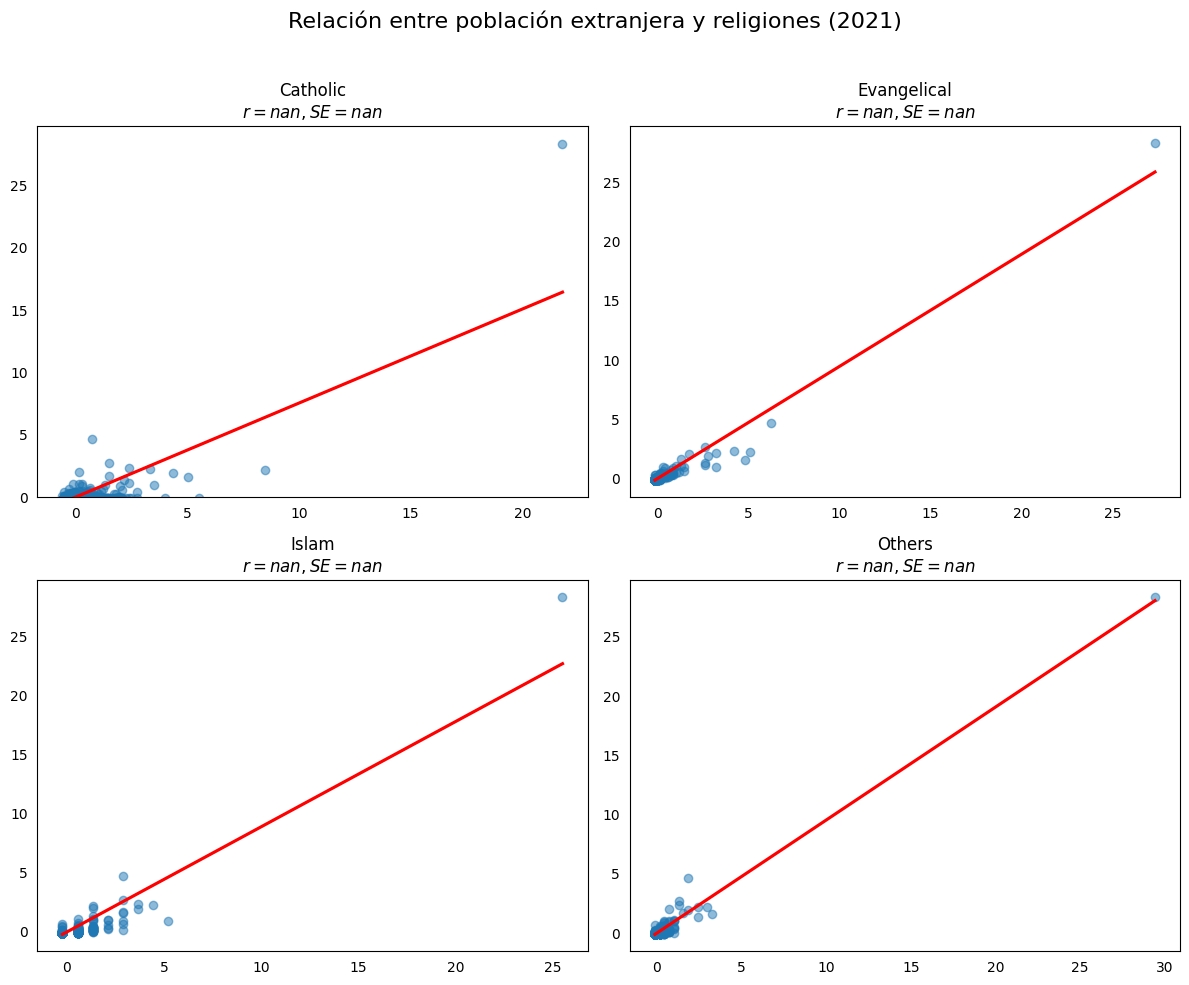

In [157]:
import seaborn as sns
from scipy.stats import linregress

# Subgráficos para cada correlación
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Definir los pares de datos y los títulos
pairs = [
    ('Zscore_catholic_2021', 'Catholic'),
    ('Zscore_evangelical_2021', 'Evangelical'),
    ('Zscore_islam_2021', 'Islam'),
    ('Zscore_others_2021', 'Others')
]

# Iterar y graficar con las modificaciones solicitadas
for ax, (column, title) in zip(axes.flat, pairs):
    # Realizar la regresión lineal para obtener correlación y error
    slope, intercept, r_value, p_value, std_err = linregress(
        foreign_faith_distribution[column],
        foreign_faith_distribution['Zscore_foreign_2021']
    )
    
    # Graficar la regresión
    sns.regplot(
        x=foreign_faith_distribution[column],
        y=foreign_faith_distribution['Zscore_foreign_2021'],
        ax=ax,
        line_kws={"color": "red"},
        scatter_kws={"alpha": 0.5},
        ci=None  # Quitar la sombra para un gráfico más limpio
    )
    
    # Personalizar el gráfico
    ax.set_title(f"{title}\n$r={r_value:.2f}, SE={std_err:.2f}$")  # Mostrar correlación y error en el título
    ax.tick_params(axis='both', which='both', bottom=False, left=False)  # Quitar ticks
    
    # Limitar eje Y para "Catholic"
    if title == 'Catholic':
        ax.set_ylim(0, None)  # Limitar el eje Y a valores no negativos
    
    # Eliminar las etiquetas de los ejes
    ax.set_xlabel("")
    ax.set_ylabel("")

# Título principal y ajuste del diseño
plt.suptitle("Relación entre población extranjera y religiones (2021)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


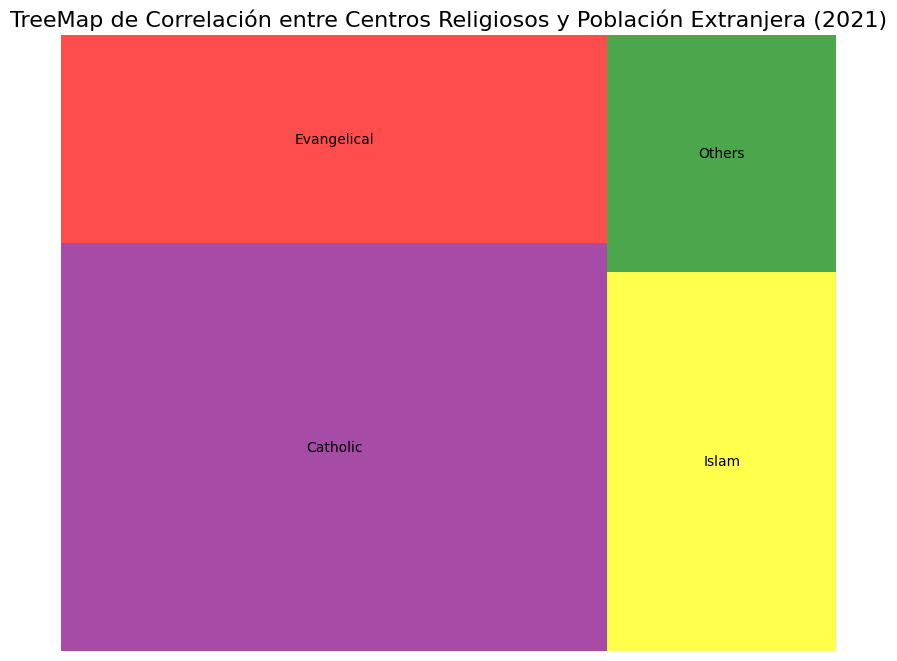

In [160]:
import matplotlib.pyplot as plt
import squarify

# Datos de correlaciones
correlations = {
    'Catholic': 0.77, 
    'Evangelical': 0.55, 
    'Islam': 0.48, 
    'Others': 0.38
}

# Normalizar las correlaciones (hacemos una transformación exponencial para amplificar las diferencias)
# Esto hará que las diferencias pequeñas en las correlaciones se agranden visualmente.
scaled_values = [correlation**2 for correlation in correlations.values()]

# Crear el TreeMap
fig, ax = plt.subplots(figsize=(10, 8))

# Colores para cada categoría
colors = ['purple', 'red', 'yellow', 'green']

# Crear los rectángulos del TreeMap
squarify.plot(sizes=scaled_values, label=correlations.keys(), color=colors, alpha=0.7)

# Títulos y etiquetas
plt.title("TreeMap de Correlación entre Centros Religiosos y Población Extranjera (2021)", fontsize=16)
plt.axis('off')  # Quitar los ejes para que solo se vea el TreeMap

# Mostrar el gráfico
plt.show()


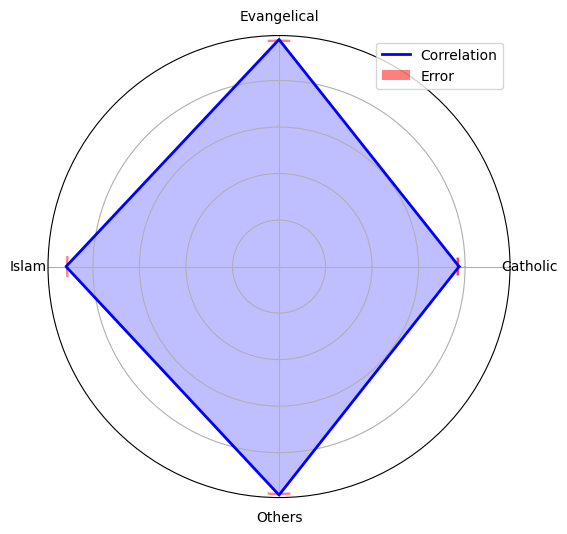

<Figure size 640x480 with 0 Axes>

In [166]:
import matplotlib.pyplot as plt
import numpy as np

# Correlaciones y errores
correlations = {
    'Catholic': correlation_catholic, 
    'Evangelical': correlation_evangelical, 
    'Islam': correlation_islam, 
    'Others': correlation_others
}
errors = {
    'Catholic': 0.01, 
    'Evangelical': 0.01, 
    'Islam': 0.01, 
    'Others': 0.01
}

# Crear una lista de categorías
categories = list(correlations.keys())

# Convertir las correlaciones y errores en arrays de numpy
correlation_values = np.array(list(correlations.values()))
error_values = np.array(list(errors.values()))

# Número de categorías (en este caso son 4)
num_vars = len(categories)

# Ángulos de cada categoría para el gráfico radar (equidistantes)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Cerrar el gráfico uniendo el último punto con el primero
correlation_values = np.concatenate((correlation_values,[correlation_values[0]]))
error_values = np.concatenate((error_values,[error_values[0]]))
angles += angles[:1]

# Crear la figura
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Graficar las correlaciones
ax.plot(angles, correlation_values, color='blue', linewidth=2, label='Correlation')

# Rellenar las áreas del gráfico
ax.fill(angles, correlation_values, color='blue', alpha=0.25)

# Graficar los errores como barras
ax.bar(angles, error_values, width=0.1, bottom=correlation_values - error_values, color='red', alpha=0.5, label='Error')

# Personalizar el gráfico
ax.set_yticklabels([])  # Quitar las etiquetas del eje radial
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Título del gráfico
plt.title("", fontsize=16)

# Añadir leyenda
plt.legend(loc='upper right')

# Mostrar el gráfico
plt.show()

#SAVE
plt.savefig('correlation_radar_chart.jpg', bbox_inches='tight')

## PLOT FOREIGN POPULATION DISTRIBUTION MAP

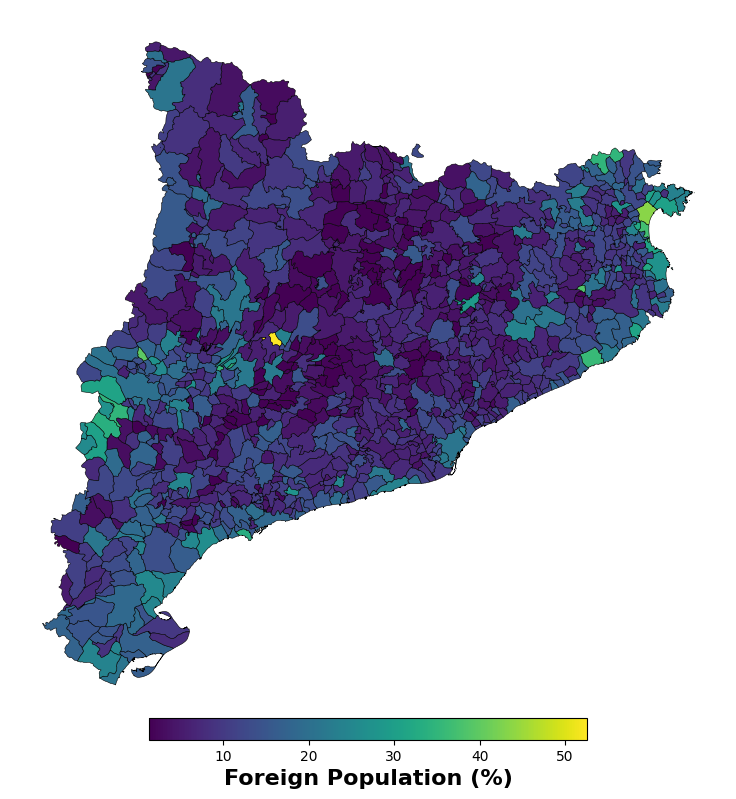

In [42]:
# Column plotted
variable_name='Población extranjera. % sobre (1)'

# Asegurarse de que las geometrías sean válidas
foreign_faith_distribution = foreign_faith_distribution.set_geometry("geometry")
foreign_faith_distribution = foreign_faith_distribution[foreign_faith_distribution.is_valid]

# Asegurar que hay un CRS válido
if foreign_faith_distribution.crs is None:
    foreign_faith_distribution = foreign_faith_distribution.set_crs("EPSG:4326", allow_override=True)

# Reproyectar si es necesario
foreign_faith_distribution = foreign_faith_distribution.to_crs("EPSG:3857")

# Reemplazar NaN con -1 (opcional, aunque no necesario para missing_kwds)
foreign_faith_distribution[variable_name] = foreign_faith_distribution[variable_name].replace({np.nan: -1})

# Crear colormap
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=foreign_faith_distribution[variable_name].replace({-1: np.nan}).min(),
                         vmax=foreign_faith_distribution[variable_name].replace({-1: np.nan}).max())

# Plot
foreign_people_distribution_fig, ax = plt.subplots(1, 1, figsize=(12, 10))

foreign_faith_distribution.plot(
    column=variable_name,
    cmap=cmap,
    norm=norm,
    linewidth=0.4,
    edgecolor='black',
    legend=False,
    legend_kwds={'label': "Foreign population (%)"},
    missing_kwds={
        "color": "lightgrey",  # Color para municipios sin datos
        "label": "No Data"     # Etiqueta en la leyenda para municipios sin datos
    },
    ax=ax
)

# Crear la barra de color (colorbar) y asociarla con el eje 'ax' en horizontal
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Se necesita para que funcione ScalarMappable sin datos adicionales
cbar = foreign_people_distribution_fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.03, pad=0.001)  # Barra de color horizontal

# Personalizar la etiqueta de la barra de color
cbar.set_label('Foreign Population (%)', fontsize=16, fontweight='bold')

# Ajustar el espacio para que la barra de color no se solape con el gráfico
foreign_people_distribution_fig.subplots_adjust(bottom=0.15)

# Quitar ejes
ax.set_axis_off()

# Mostrar la figura
plt.show()

## NORMALISED RELIGION DISTRIBUTION

Check columns and NaN values (lack of data for some municipalities)

In [43]:
foreign_faith_distribution.columns
print(foreign_faith_distribution['Catholic_2020'].isna().sum())

4


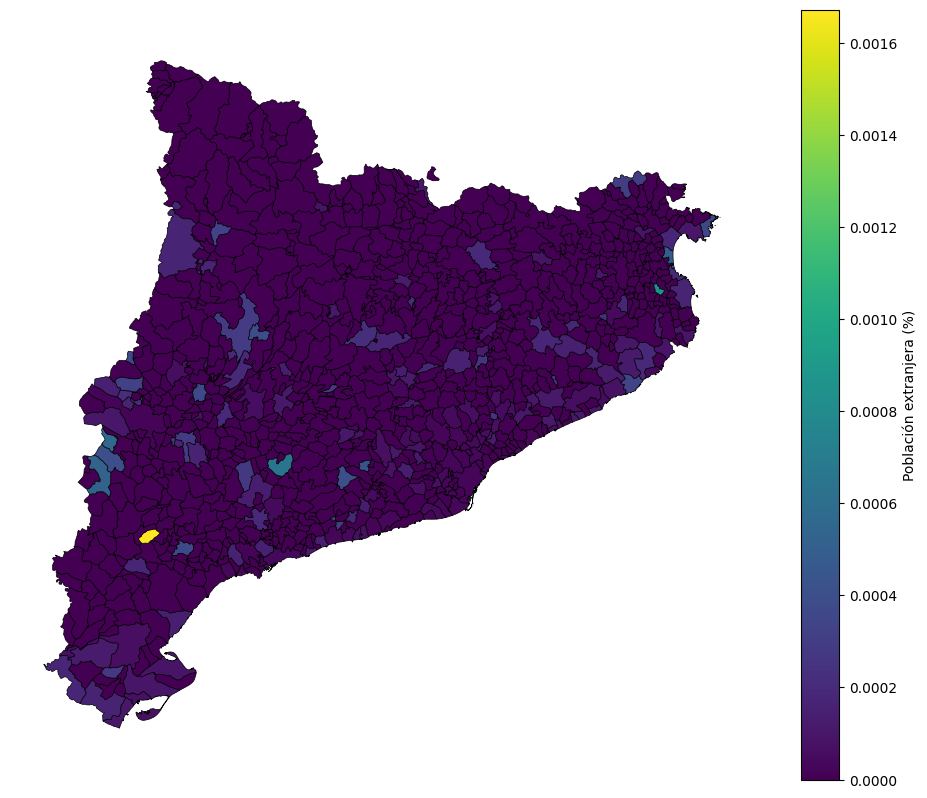

In [44]:
# Column plotted
variable_name='Normalised_islam_2021'

# Asegurarse de que las geometrías sean válidas
foreign_faith_distribution = foreign_faith_distribution.set_geometry("geometry")
foreign_faith_distribution = foreign_faith_distribution[foreign_faith_distribution.is_valid]

# Asegurar que hay un CRS válido
if foreign_faith_distribution.crs is None:
    foreign_faith_distribution = foreign_faith_distribution.set_crs("EPSG:4326", allow_override=True)

# Reproyectar si es necesario
foreign_faith_distribution = foreign_faith_distribution.to_crs("EPSG:3857")

# Reemplazar NaN con -1 (opcional, aunque no necesario para missing_kwds)
foreign_faith_distribution[variable_name] = foreign_faith_distribution[variable_name].replace({np.nan: -1})

# Crear colormap
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=foreign_faith_distribution[variable_name].replace({-1: np.nan}).min(),
                         vmax=foreign_faith_distribution[variable_name].replace({-1: np.nan}).max())

# Plot
islam_distribution21_fig, ax = plt.subplots(1, 1, figsize=(12, 10))

foreign_faith_distribution.plot(
    column=variable_name,
    cmap=cmap,
    norm=norm,
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Población extranjera (%)"},
    missing_kwds={
        "color": "lightgrey",  # Color para municipios sin datos
        "label": "No Data"     # Etiqueta en la leyenda para municipios sin datos
    },
    ax=ax
)

# Quitar ejes
ax.set_axis_off()

plt.show()


SAVE IMAGES

In [155]:
foreign_people_distribution_fig.savefig("foreign_people_distribution.jpg", format="jpg",dpi=300,bbox_inches="tight")

## INCLUDE BUBBLES FOR CENTRES IN THE MAP

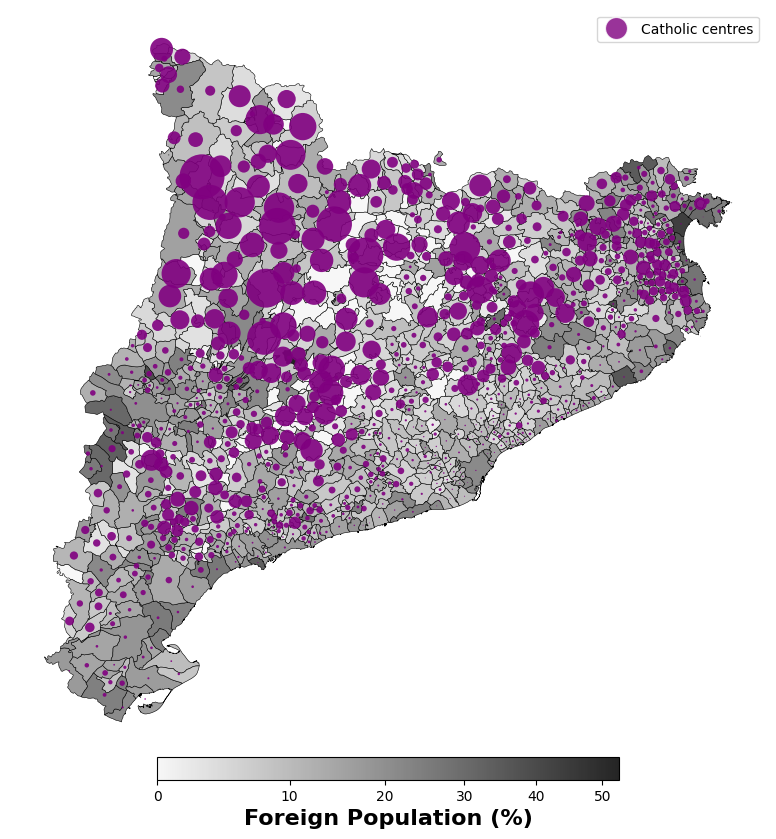

In [143]:
## RELIGION
religion_point = 'Normalised_catholic_2021'
variable_name = 'Población extranjera. % sobre (1)'  # Nombre de la columna para el mapa principal

# Asegurar que las geometrías son válidas
foreign_faith_distribution = foreign_faith_distribution.set_geometry("geometry")
foreign_faith_distribution = foreign_faith_distribution[foreign_faith_distribution.is_valid]

# Asegurar que hay un CRS válido
if foreign_faith_distribution.crs is None:
    foreign_faith_distribution = foreign_faith_distribution.set_crs("EPSG:4326", allow_override=True)

# Reproyectar a un CRS adecuado para visualización
foreign_faith_distribution = foreign_faith_distribution.to_crs("EPSG:3857")

# Reemplazar NaN en la columna del mapa principal con un valor adecuado
foreign_faith_distribution[variable_name] = foreign_faith_distribution[variable_name].replace({np.nan: -1})

# Crear colormap
# Crear un colormap monocromático de escala de grises personalizada
custom_greys = LinearSegmentedColormap.from_list("CustomGreys", ["#f7f7f7", "#252525"])
cmap = custom_greys
# Ajusta gamma (más bajo, más intenso)
norm = PowerNorm(gamma=0.7, vmin=foreign_faith_distribution[variable_name].replace({-1: np.nan}).min(), 
                 vmax=foreign_faith_distribution[variable_name].replace({-1: np.nan}).max())  

# Crear la figura y el eje
faith_distribution_fig1, ax = plt.subplots(1, 1, figsize=(12, 10))

# Graficar el shapefile con el colormap sin leyenda automática
foreign_faith_distribution.plot(
    column=variable_name,
    cmap=cmap,
    norm=norm,
    linewidth=0.4,
    edgecolor='black',
    legend=False,
    missing_kwds={
        "color": "lightgrey",  # Color para áreas sin datos
        "label": "No Data"     # Etiqueta en la leyenda
    },
    ax=ax
)

# Crear la barra de color (colorbar) y asociarla con el eje 'ax' en horizontal
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = foreign_people_distribution_fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.03, pad=0.001)
cbar.set_label('Foreign Population (%)', fontsize=16, fontweight='bold')

# Ajustar el espacio para que la barra de color no se solape con el gráfico
foreign_people_distribution_fig.subplots_adjust(bottom=0.15)

# Quitar los ejes
ax.set_axis_off()

# Filtrar datos válidos para la columna de puntos
foreign_faith_distribution_valid = foreign_faith_distribution[
    foreign_faith_distribution[religion_point].notna() & 
    (foreign_faith_distribution[religion_point] > 0)
]

# Verificar que hay datos válidos para graficar puntos
if not foreign_faith_distribution_valid.empty:
    # Obtener los centroides de los municipios válidos
    foreign_faith_distribution_valid = foreign_faith_distribution_valid[
        foreign_faith_distribution_valid.geometry.is_valid
    ]
    centroides = foreign_faith_distribution_valid.geometry.centroid

    # Escalar el tamaño de los puntos proporcional al valor en 'religion_point'
    sizes = foreign_faith_distribution_valid[religion_point] * 6000
    sizes = sizes.fillna(0.1)  # Reemplazar NaN con un tamaño mínimo
    sizes = sizes.clip(lower=0.1)  # Asegurar que los tamaños sean mayores a 0

    # Graficar los puntos con tamaños ajustados
    ax.scatter(
        centroides.x,
        centroides.y,
        s=sizes,
        color='purple',
        alpha=0.9,
        edgecolors='none',
    )
# Agregar una leyenda para los puntos con el mismo tamaño en la leyenda
from matplotlib.legend_handler import HandlerTuple

# Crear un tamaño uniforme para los puntos en la leyenda
legend_points = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=16, alpha=0.8, label='Catholic centres'),
]

ax.legend(handles=legend_points)

# Mostrar el mapa
plt.show()
faith_distribution_fig1.savefig("faith_distribution1.png", format="jpg",dpi=300,bbox_inches="tight")

## Overlap of more bubbles

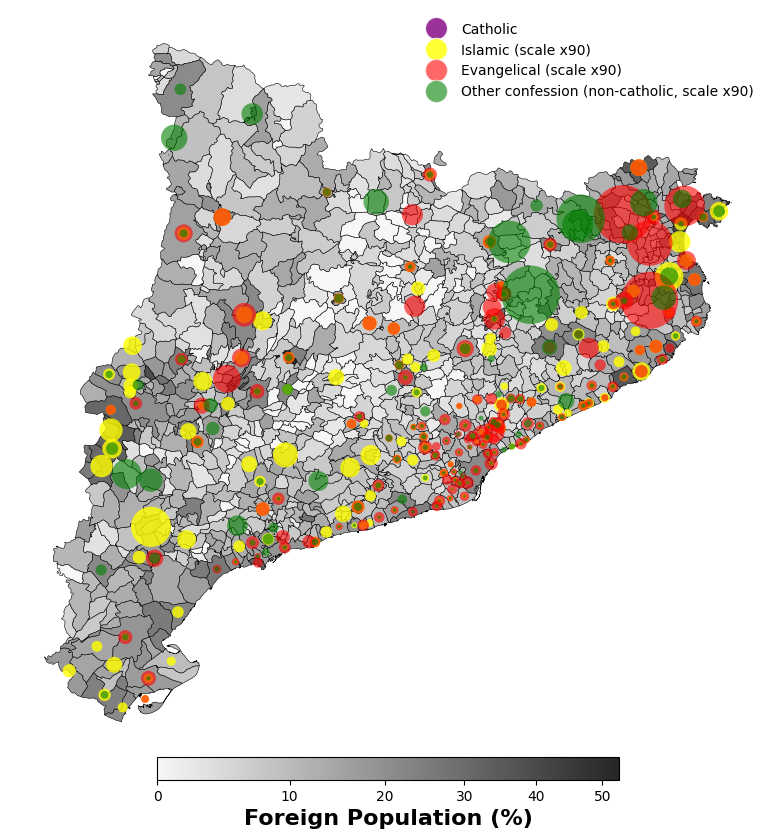

In [142]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Variables de entrada
religion_point = 'Normalised_islam_2021'
religion_point2 = 'Normalised_evangelical_2021'
religion_point3 = 'Normalised_others_2021'
variable_name = 'Población extranjera. % sobre (1)'  # Nombre de la columna para el mapa principal

# Asegurar que las geometrías son válidas
foreign_faith_distribution = foreign_faith_distribution.set_geometry("geometry")
foreign_faith_distribution = foreign_faith_distribution[foreign_faith_distribution.is_valid]

# Asegurar que hay un CRS válido
if foreign_faith_distribution.crs is None:
    foreign_faith_distribution = foreign_faith_distribution.set_crs("EPSG:4326", allow_override=True)

# Reproyectar a un CRS adecuado para visualización
foreign_faith_distribution = foreign_faith_distribution.to_crs("EPSG:3857")

# Reemplazar NaN en la columna del mapa principal con un valor adecuado
foreign_faith_distribution[variable_name] = foreign_faith_distribution[variable_name].replace({np.nan: -1})

# Crear colormap
# Crear un colormap monocromático de escala de grises personalizada
custom_greys = LinearSegmentedColormap.from_list("CustomGreys", ["#f7f7f7", "#252525"])
cmap = custom_greys

# Ajusta gamma (más bajo, más intenso)
norm = PowerNorm(gamma=0.7, vmin=foreign_faith_distribution[variable_name].replace({-1: np.nan}).min(), 
                 vmax=foreign_faith_distribution[variable_name].replace({-1: np.nan}).max())  

# Crear la figura y el eje
faith_distribution_fig2, ax = plt.subplots(1, 1, figsize=(12, 10))

# Graficar el shapefile con el colormap sin leyenda automática
foreign_faith_distribution.plot(
    column=variable_name,
    cmap=cmap,
    norm=norm,
    linewidth=0.4,
    edgecolor='black',
    legend=False,
    missing_kwds={
        "color": "lightgrey",  # Color para áreas sin datos
        "label": "No Data"     # Etiqueta en la leyenda
    },
    ax=ax
)

# Crear la barra de color (colorbar) y asociarla con el eje 'ax' en horizontal
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = foreign_people_distribution_fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.03, pad=0.001)
cbar.set_label('Foreign Population (%)', fontsize=16, fontweight='bold')

# Ajustar el espacio para que la barra de color no se solape con el gráfico
foreign_people_distribution_fig.subplots_adjust(bottom=0.15)

# Quitar los ejes
ax.set_axis_off()

# Filtrar datos válidos para la columna de puntos (Islam)
foreign_faith_distribution_valid = foreign_faith_distribution[
    foreign_faith_distribution[religion_point].notna() & 
    (foreign_faith_distribution[religion_point] > 0)
]

# Verificar que hay datos válidos para graficar puntos
if not foreign_faith_distribution_valid.empty:
    # Obtener los centroides de los municipios válidos
    foreign_faith_distribution_valid = foreign_faith_distribution_valid[
        foreign_faith_distribution_valid.geometry.is_valid
    ]
    centroides = foreign_faith_distribution_valid.geometry.centroid

    # Escalar el tamaño de los puntos proporcional al valor en 'religion_point'
    sizes = foreign_faith_distribution_valid[religion_point] * 500000
    sizes = sizes.fillna(0.1)  # Reemplazar NaN con un tamaño mínimo
    sizes = sizes.clip(lower=0.1)  # Asegurar que los tamaños sean mayores a 0

    # Graficar los puntos con tamaños ajustados
    ax.scatter(
        centroides.x,
        centroides.y,
        s=sizes,
        color='yellow',
        alpha=0.8,
        edgecolors='none',
        label=f'Islam centres'
    )

# Filtrar datos válidos para la segunda columna de puntos (evangelican)
foreign_faith_distribution_valid2 = foreign_faith_distribution[
    foreign_faith_distribution[religion_point2].notna() & 
    (foreign_faith_distribution[religion_point2] > 0)
]

# Verificar que hay datos válidos para graficar los nuevos puntos
if not foreign_faith_distribution_valid2.empty:
    # Obtener los centroides de los municipios válidos
    foreign_faith_distribution_valid2 = foreign_faith_distribution_valid2[
        foreign_faith_distribution_valid2.geometry.is_valid
    ]
    centroides2 = foreign_faith_distribution_valid2.geometry.centroid

    # Escalar el tamaño de los puntos proporcional al valor en 'religion_point2'
    sizes2 = foreign_faith_distribution_valid2[religion_point2] * 500000
    sizes2 = sizes2.fillna(0.1)  # Reemplazar NaN con un tamaño mínimo
    sizes2 = sizes2.clip(lower=0.1)  # Asegurar que los tamaños sean mayores a 0

    # Graficar los nuevos puntos con tamaños ajustados
    ax.scatter(
        centroides2.x,
        centroides2.y,
        s=sizes2,
        color='red',  # Color diferente para distinguirlo de los primeros puntos
        alpha=0.6,
        edgecolors='none',
        label=f'Evangelical centres'
    )

# Filtrar datos válidos para la segunda columna de puntos (others)
foreign_faith_distribution_valid3 = foreign_faith_distribution[
    foreign_faith_distribution[religion_point3].notna() & 
    (foreign_faith_distribution[religion_point3] > 0)
]

# Verificar que hay datos válidos para graficar los nuevos puntos
if not foreign_faith_distribution_valid3.empty:
    # Obtener los centroides de los municipios válidos
    foreign_faith_distribution_valid3 = foreign_faith_distribution_valid3[
        foreign_faith_distribution_valid3.geometry.is_valid
    ]
    centroides3 = foreign_faith_distribution_valid3.geometry.centroid

    # Escalar el tamaño de los puntos proporcional al valor en 'religion_point3'
    sizes3 = foreign_faith_distribution_valid3[religion_point3] * 200000
    sizes3 = sizes3.fillna(0.1)  # Reemplazar NaN con un tamaño mínimo
    sizes3 = sizes3.clip(lower=0.1)  # Asegurar que los tamaños sean mayores a 0

    # Graficar los nuevos puntos con tamaños ajustados
    ax.scatter(
        centroides3.x,
        centroides3.y,
        s=sizes3,
        color='green',  # Color diferente para distinguirlo de los primeros puntos
        alpha=0.6,
        edgecolors='none',
        label=f'Other non-catholic centres'
    )

# Agregar una leyenda para los puntos con el mismo tamaño en la leyenda
from matplotlib.legend_handler import HandlerTuple

# Crear un tamaño uniforme para los puntos en la leyenda
legend_points = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=16, alpha=0.8, label='Catholic'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=16, alpha=0.8, label='Islamic'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=16, alpha=0.6, label='Evangelical'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=16, alpha=0.6, label='Other confession (non-catholic)')
]

ax.legend(handles=legend_points, frameon=False)

# Mostrar el mapa
plt.show()
faith_distribution_fig2.savefig("faith_distribution2.png", format="jpg",dpi=300,bbox_inches="tight")